# Cosmic Extractor v2.1
Because I had to copy it to a new file.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy import ndimage

from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize # For displaying the preproc images

import os
import re
import glob
import json
from pathlib import Path
import time

import joincosmics

In [2]:
# Took this from DESIspec.
def parse_sec_keyword(value):
    m = re.search(r'\[(\d+):(\d+)\,(\d+):(\d+)\]', value)
    if m is None:
        m = re.search(r'\[(\d+):(\d+)\, (\d+):(\d+)\]', value)
        if m is None :
            raise ValueError('unable to parse {} as [a:b, c:d]'.format(value))

    xmin, xmax, ymin, ymax = tuple(map(int, m.groups()))

    return np.s_[ymin - 1:ymax, xmin - 1:xmax]

# Subtracts off the bias overscan region to normalize the four quadrants.
def subtract_bias(img, camera, hdus):
    # Camera defines which camera to use, e.x. "R5"
    quads = ["A", "B", "C", "D"]
    corners = {}

    for q in quads:
        # Gets the data from the overscan region and subtracts the median from the data region.
        # More accurate would be to median each row or column etc but this is quick and dirty.
        o_i = parse_sec_keyword(hdus[camera].header["ORSEC" + q])
        d_i = parse_sec_keyword(hdus[camera].header["DATASEC" + q])
        overscan = img[o_i].copy()
        corners[q] = img[d_i] - np.median(overscan)
        
    # Smash the corners back together to make the large image.
    lower = np.concatenate((corners["A"], corners["B"]), axis=1)
    higher = np.concatenate((corners["C"], corners["D"]), axis=1)
    return np.concatenate((lower, higher), axis=0)

def pretty_disp(img):
    # Normalization to display the image nicer.
    zscale = ZScaleInterval()
    norm = ImageNormalize(img, zscale)

    fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
    ax.imshow(img, cmap='gray', origin="lower", interpolation="none", norm=norm)

In [3]:
# Time to make some dark medians.
d = "20200209"
ims = ["00047922", "00047911", "00047914", "00047920", "00047940", "00047909", "00047935"]

# d = "20200608"  #450s
# ims = ["00056648", "00056644", "00056645", "00056646", "00056647"]

ROOT = Path('/project/projectdirs/desi/spectro/data/')
ROOT_PRE = Path('/project/projectdirs/desi/spectro/redux/daily/preproc/')

00047922
00047911
00047914
00047920
00047940
00047909
00047935
Loaded


Text(0.5, 1.0, 'Dark Median 600s Camera R4')

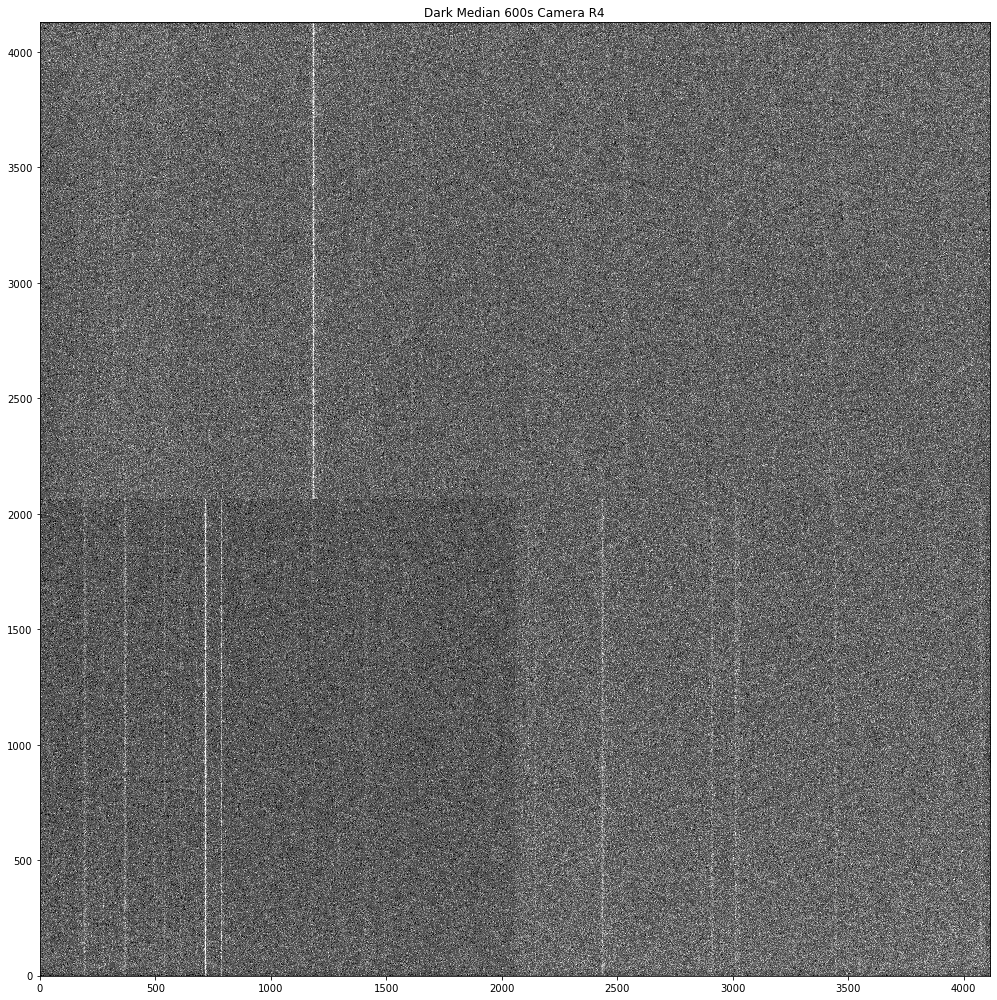

In [4]:
sup = np.zeros((4128, 4114, 1))
cam = "R4"

# Load the image, subtract the bias and concatenate it to the "super" image.
# Super image is just all the images stacked on top of each other.
for i in ims:
    print(i)
    hdus = fits.open(os.path.join(ROOT, str(d), i, f"desi-{i}.fits.fz"))
    img = hdus[cam].data
    if int(hdus[cam].header['EXPTIME']) > 0:
        img = subtract_bias(img, cam, hdus)
        temp = img.reshape(img.shape[0], img.shape[1], 1)
        sup = np.concatenate((sup, temp), axis=2)

print("Loaded")

# This is when we do the actual median, we just take a median along the "stack" axis
final = np.median(sup, axis=2)

# Display the final result!
zscale = ZScaleInterval()
norm = ImageNormalize(final, zscale)
fig, ax = plt.subplots(1, 1, figsize=(14, 14), tight_layout=True)
ax.imshow(final, cmap='gray', origin="lower", interpolation="none", norm=norm)
plt.title(f"Dark Median 600s Camera {cam}")

Num bins  2.0
Median 0.0
STD 0.6042952069538243
2xSTD 1.2085904139076487
3xSTD 1.812885620861473


Text(0.5, 0, 'Pixel value')

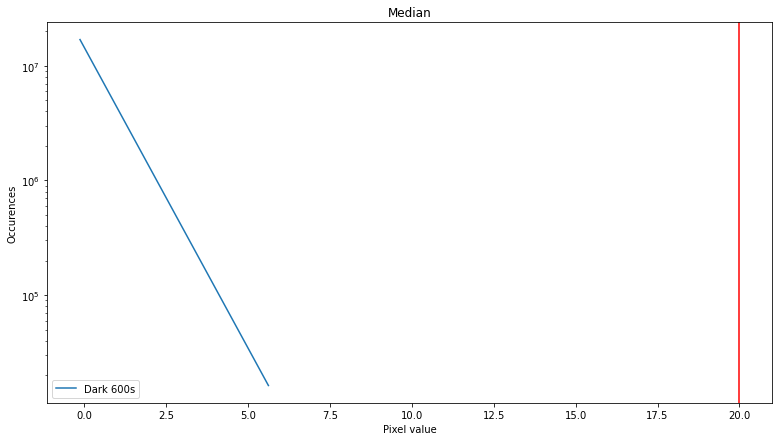

In [5]:
# Upper limit on pixel value
max_pix_val = 1200

fig, ax = plt.subplots(figsize=(13, 7))

hist_img = final[final > -5]
to_hist = hist_img[hist_img < max_pix_val].flatten()
num_bins = (to_hist.max() - to_hist.min()) // 4

# Printing the number of bins just for edification.
print("Num bins ", num_bins)

# Generate the histogram (obv lol)
n, bins = np.histogram(to_hist, bins=int(num_bins))
width = (bins[1] - bins[0]) / 2

# Smooth the histogram a bit using the following 5 item kernel
# A weighted average that considers the bin position more than
# the two adjacent bins more than the two adjacent adjacent bins.
k = np.asarray([1]) 
# k = np.asarray([1, 2, 3, 2, 1]) 
k = k / np.sum(k)
n = np.convolve(n, k, "same")
# plt.plot(bins[:-1] + width, n, label=f"{d}: {e} {sky_time}s") 
plt.plot(bins[:-1] + width, n, label=f"Dark 600s") 
plt.axvline(x=20, c="r")

print("Median", np.median(final))
print("STD", np.std(final))
print("2xSTD", 2 * np.std(final))
print("3xSTD", 3 * np.std(final))

plt.legend()
plt.yscale("log")
plt.title(f"Median")
plt.ylabel("Occurences")
plt.xlabel("Pixel value")

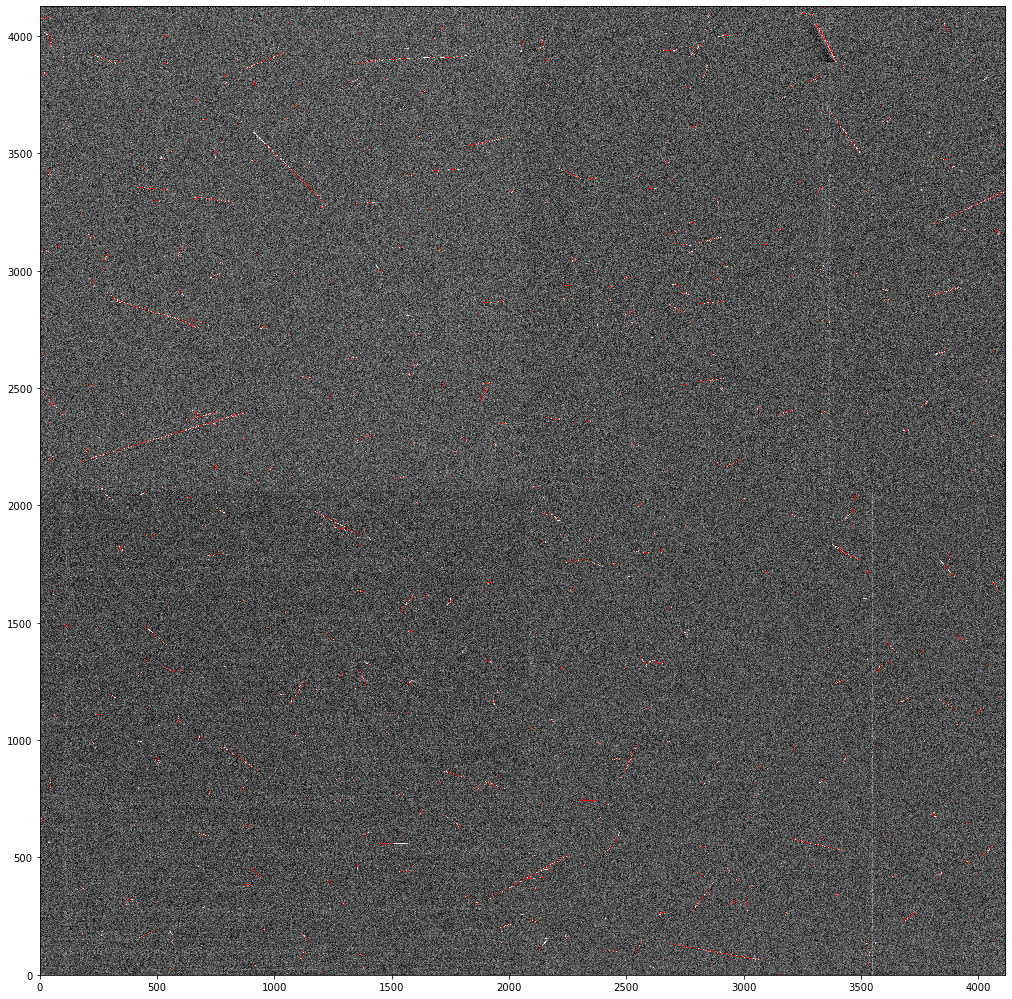

In [6]:
d, e = "20191108", "00025659"
dark_hdus = fits.open(os.path.join(ROOT, d, e, f"desi-{e}.fits.fz"))
dark_img = dark_hdus["R1"].data
dark_img = subtract_bias(dark_img, "R1", dark_hdus)

cosmic_thresh = 100
mask_img = np.ma.masked_where(dark_img > cosmic_thresh, dark_img)

cmap = cm.gray
cmap.set_bad(color="red")

zscale = ZScaleInterval()
norm = ImageNormalize(dark_img, zscale)
fig, ax = plt.subplots(1, 1, figsize=(14, 14), tight_layout=True)
ax.imshow(mask_img, cmap=cmap, origin="lower", interpolation="none", norm=norm)

In this cell I run a small loop that basically "flood fills" the cosmic outward. From the histogram analyses we have determined that above pixel value 600 all pixels are cosmic rays as it does not seem that the data gets this high. In darks there is not data, so we can use ~100 as a pixel seed value. From these individual (or multiple) pixels we expand each pixel outward using a 3x3 convolution kernel, then remove any pixels where the pixel value has fallen below the shot noise into the actual background of the dark ($3\sigma$ of the median dark). This lets us expand cosmic rays outwards from pixels we know are cosmic rays into every pixel that could reasonably be a part of this cosmic ray.

Finally we plot the new cosmic mask against the seed cosmic mask.

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
22.38246750831604


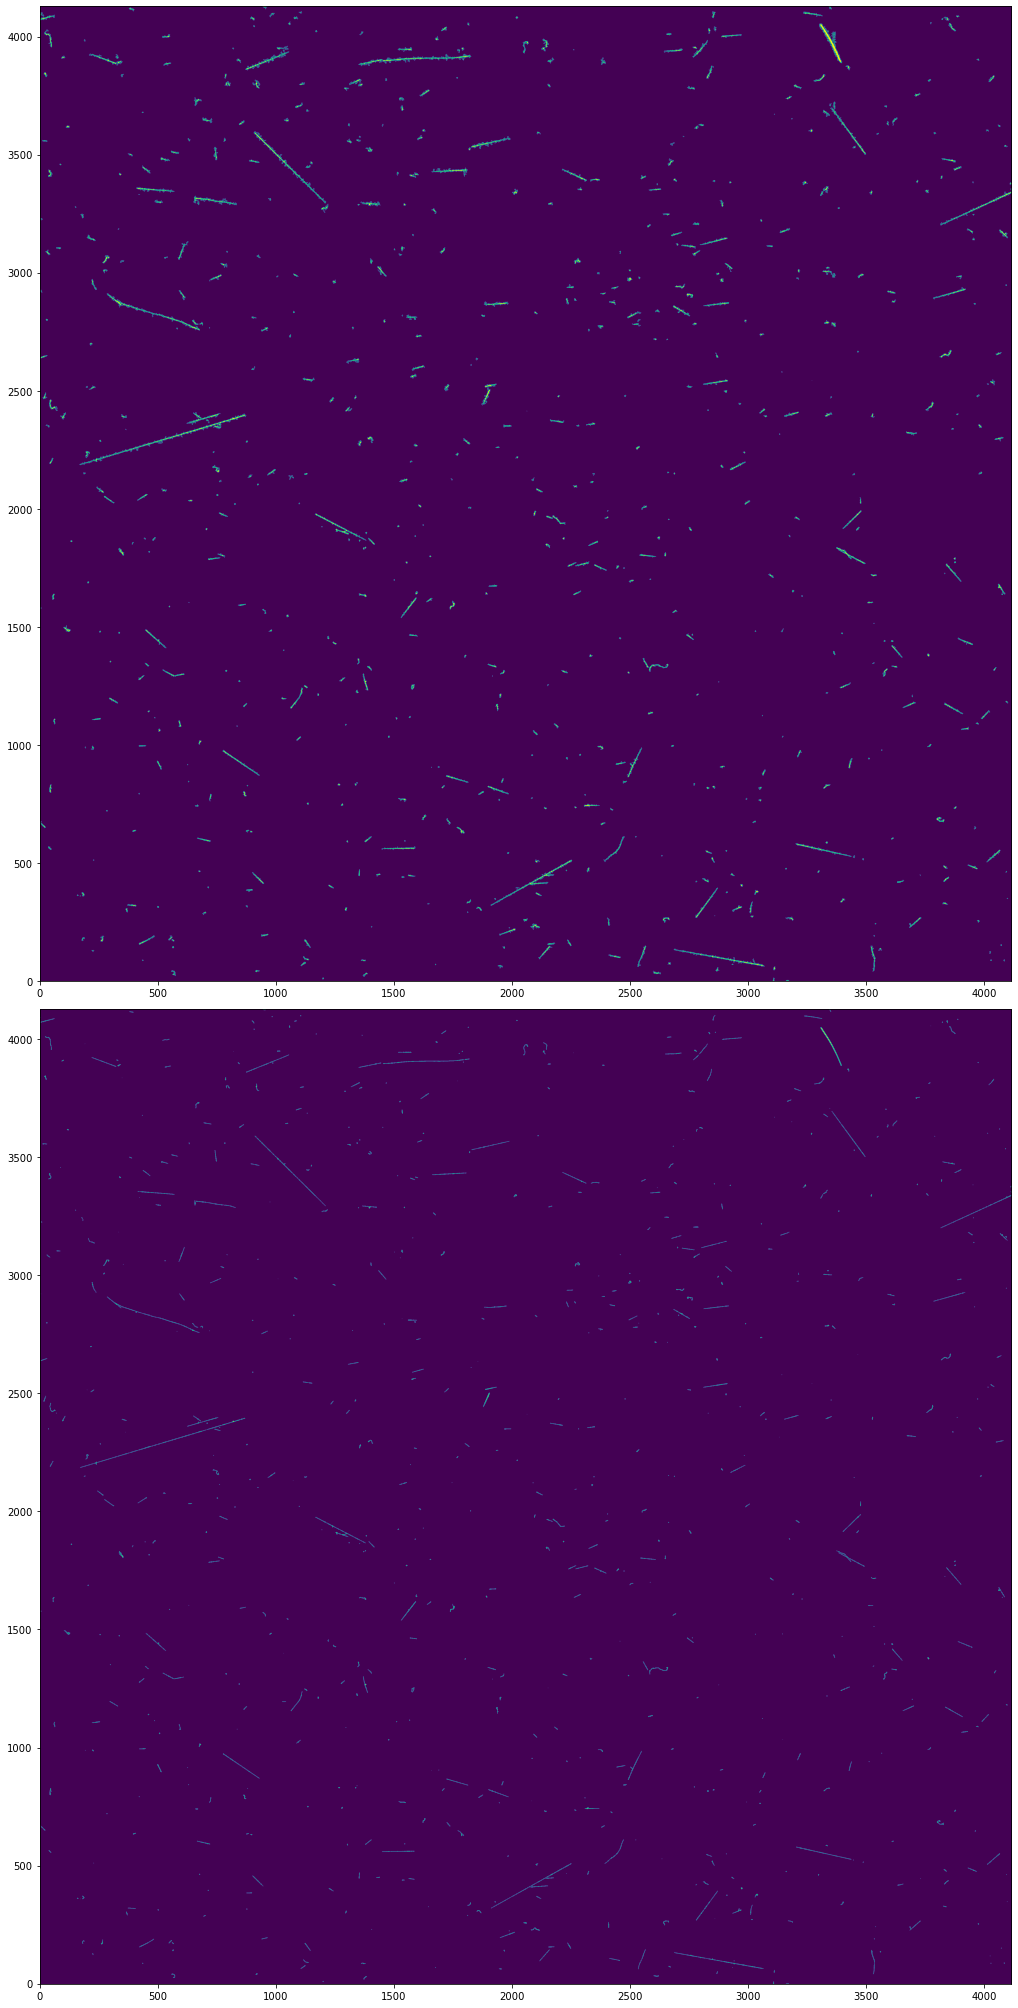

In [7]:
cosmic_thresh = 250
m = dark_img > cosmic_thresh
good = dark_img > 3 * np.std(final)

k = np.ones((3, 3))
prev = 0
i = 0
t1 = time.time()
while(np.sum(m) - prev) > 0:
    prev = np.sum(m)
    i += 1 
    print("Iteration", i)
    m = ndimage.convolve(m, k) & good
    
print(time.time() - t1)

fig, ax = plt.subplots(2, 1, figsize=(14, 28), tight_layout=True)
m1 = dark_img > cosmic_thresh
ax[0].imshow(m, origin="lower")

# zscale = ZScaleInterval()
# norm = ImageNormalize(dark_img, zscale)
ax[1].imshow(m1, origin="lower")


# ax[0].axhline(y = y_min)
# ax[0].axhline(y = y_max)
# ax[0].axvline(x = x_min)
# ax[0].axvline(x = x_max)


# ax[1].axhline(y = y_min)
# ax[1].axhline(y = y_max)
# ax[1].axvline(x = x_min)
# ax[1].axvline(x = x_max)

The above loop turned into a function.

In [8]:
def flood_cosmic(input_mask, good):
    # We don't want to actually affect the input mask.
    m = np.copy(input_mask)
    k = np.ones((3, 3))
    prev = 0
    
    # Loop over as long as no new cosmic affected pixels are added at the end of each step.
    while(np.sum(m) - prev) > 0:
        prev = np.sum(m)
        m = ndimage.convolve(m, k) & good

    return m


# ~2x faster, thanks to a slightly smarter method of running.
# Confirmed to give the same results after a binary_opening
# which is fine since we do that before cropping out the cosmics
# Future Dylan here: Turns out this is not that great.
# Future future Dylan: might just be a problem with my threshold for good. 
def flood_cosmic2(input_mask, good):
    # Label the good ones and keep only the good labels that have
    # at least one seed element from input_mask
    labeled, num = ndimage.label(good)
    good_labels = labeled[input_mask > 0]
    good_labels = np.unique(good_labels)
    
    # Keeps only the labeled regions if their label is in good label
    m = np.isin(labeled, good_labels)

    return m

In [9]:
# %timeit flood_cosmic(m1, good)
# %timeit flood_cosmic2(m1, good)
a = flood_cosmic(m1, good)
b = flood_cosmic2(m1, good)

a = ndimage.binary_opening(a, np.ones((3,3)))
b = ndimage.binary_opening(b, np.ones((3,3)))

np.all(a == b)

False

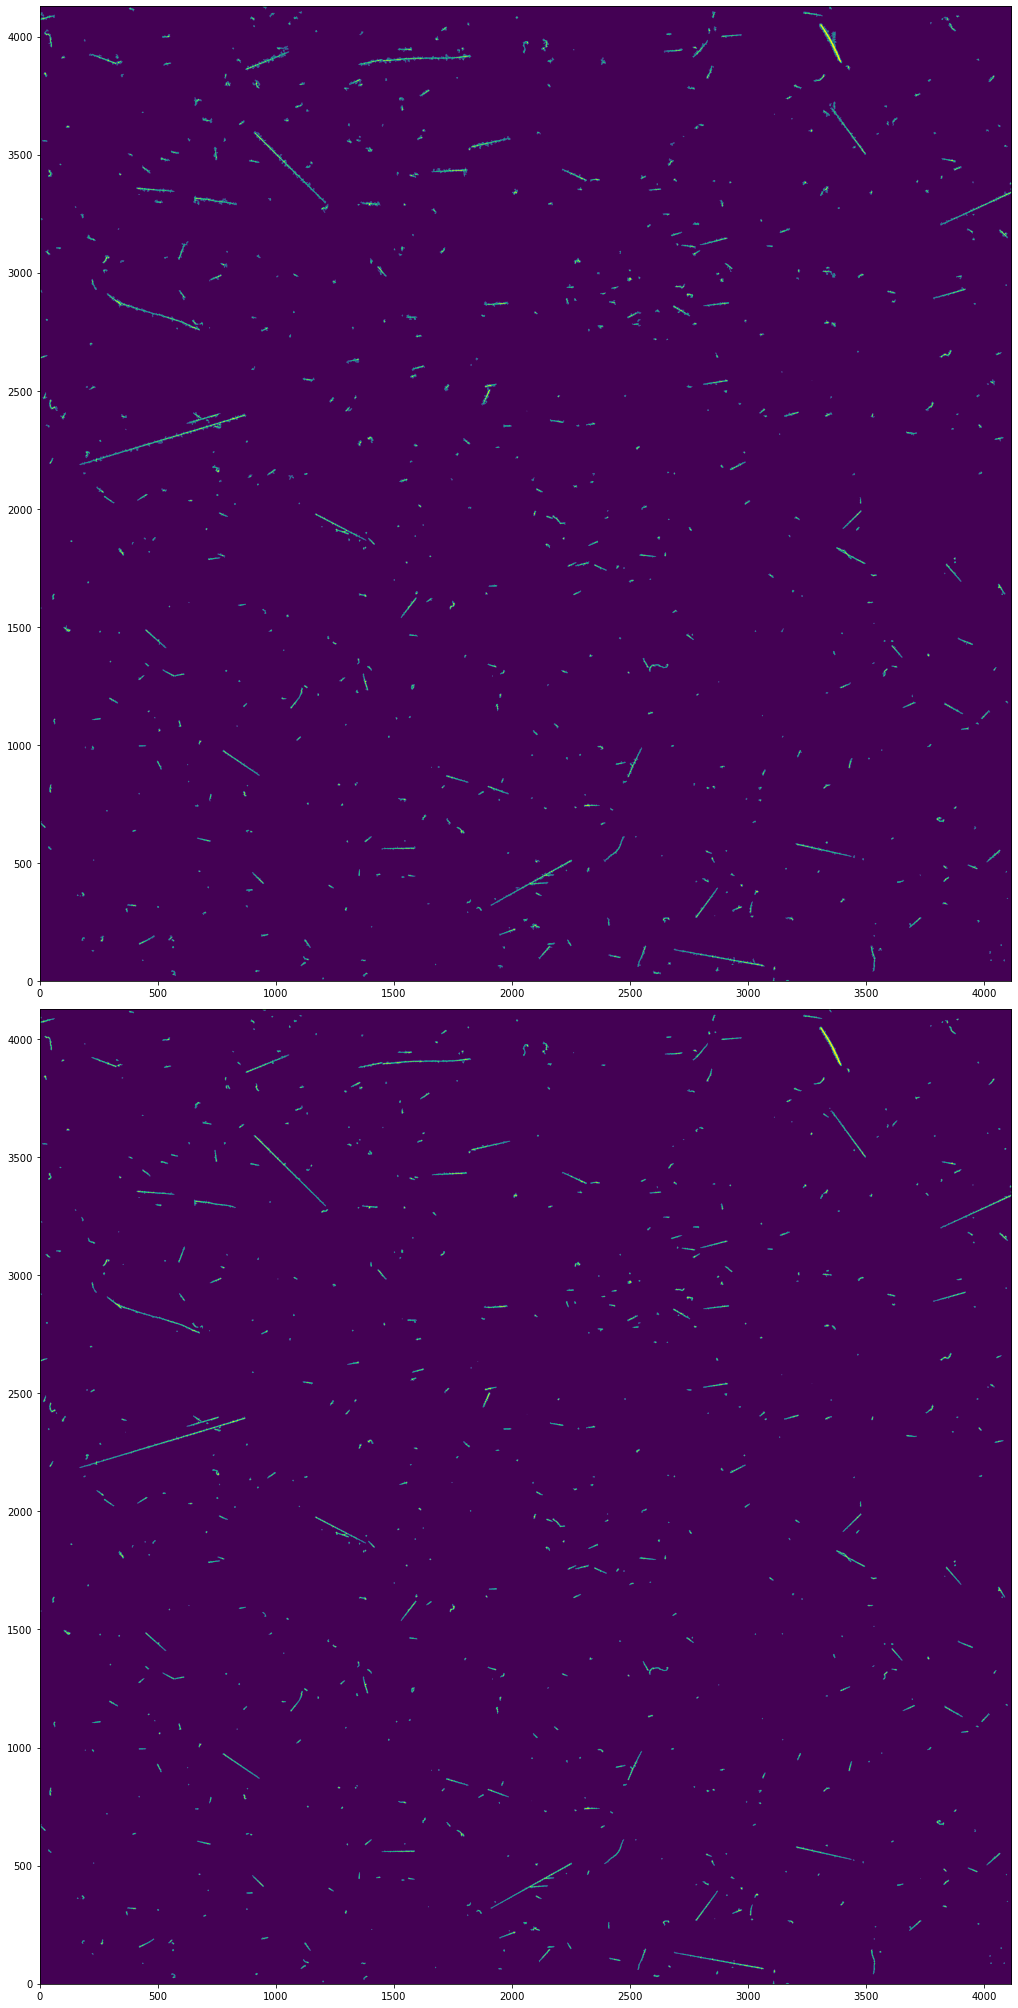

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(14, 28), tight_layout=True)
m1 = dark_img > cosmic_thresh
ax[0].imshow(flood_cosmic(m1, good), origin="lower")
ax[1].imshow(flood_cosmic2(m1, good), origin="lower")

In [40]:
# I rewrote this cell because it's bad practice to use try/except
# when you could just, you know, use if statements?

# For saving all of these so we don't need to rerun this often.
exp_times = []
num_cosmics = [] # Number of cosmics in this image
num_pixels = [] # Number of cosmic affected pixels
cosmics = []
cosmic_masks = []
# cosmic_ivar = []
cams = [] # Cam per cosmic
im_cam = [] # Cam per image not per cosmic

# cosmics = list(np.load("cosmic_data/cosmics.npy"))
# cosmic_masks = list(np.load("cosmic_data/cosmic_masks.npy"))
# # cosmic_ivar = list(np.load("cosmic_data/cosmics_ivar.npy"))
# exp_times = list(np.load("cosmic_data/exp.npy"))
# nums = list(np.load("cosmic_data/nums.npy"))
# cams = list(np.load("cosmic_data/cams.npy"))

# 20191026
# 20201108
for d in range(20191106, 20200209):
    
    # This will skip any dates that don't exist because observing didn't happen that night.
    exp_path = os.path.join(ROOT, str(d))
    if not os.path.isdir(exp_path):
        continue
        
    exps = sorted(os.listdir(exp_path))

    for e in exps:
        # We skip exposure dates that don't have a file.
        file_exists = os.path.isfile(os.path.join(exp_path, e, "desi-" + e + ".fits.fz"))
        
        # There are weird cases where the file exists and the preproc doesn't. Odd.
        if not file_exists: continue
        else:
            hdus = fits.open(os.path.join(exp_path, e, "desi-" + e + ".fits.fz"))
            
            # We don't need the sequence anymore since only spectrograph files are saved
            # as desi-e-.fits.fz, everything else is not (for ex GFA images are gfa-e-fits.fz)
            # header 1 is always a spectrograph, and exptime/flavor is same between
            # all spectrograph cameras (RBZ etc.)
            e_time = hdus[1].header['EXPTIME']
            flavor = hdus[1].header['FLAVOR']
            
            # Going for less than 1200 to avoid some overlapping cosmics.
            if flavor == 'dark' and e_time < 1200:
                for i in range(len(hdus)):
                    cam = hdus[i].name

                    # Right now we're only doing R-band images
                    if not cam.startswith("R"): continue
                        
                    print("Adding cosmics for", d, e, e_time, cam)
                    
                    # We load the preproced version of the image for the inverse variance
                    # We only really need this to experiment with the old cosmic method.
#                     ivar_path = os.path.join(ROOT_PRE, str(d), e, f"preproc-{cam.lower()}-{e}.fits")
#                     if not os.path.isfile(ivar_path): continue
#                     ivar_hdus = fits.open(os.path.join(ROOT_PRE, str(d), e, f"preproc-{cam.lower()}-{e}.fits"))

                    # Load the image and subtract the bias to normalize it
                    ii = hdus[cam].data
                    ii2 = subtract_bias(ii, cam, hdus)

                    # Join the cosmics in order to reduce the number to be closer to the true value
                    print("Flooding cosmics")
                    m = flood_cosmic2(ii2 > cosmic_thresh, ii2 > 3 * np.std(final))
                    m_binary = ndimage.binary_opening(m_binary, np.ones((3,3))) # Should remove hot pixels
                    m_binary = ndimage.convolve(m, np.ones((3,3))) # This is 50ms faster than a binary_dilation.
                    m_labels, num_labels = ndimage.label(m_binary, structure=np.ones((3,3)))
                    print("Cosmics flooded, adding")

                    # Ok so 0 is the non labeled ones so we have to start at 1
                    size = 0
                    rejected = 0
                    for i in range(1, num_labels):
                        points = np.argwhere(m_labels == i)
                        
                        # We do y this way because interplay between the origin of the array being the
                        # top left of the image and the image actually being displayed in the opposite
                        # vertical orientation (origin lower left)
                        # This is also why the max is from the min and the min is from the max.
                        y_min = np.min(points[:,0])
                        y_max = np.max(points[:,0])
                        x_min = np.min(points[:,1])
                        x_max = np.max(points[:,1])
                        
                        # These are much too large to be reasonable cosmics.
                        size_thresh = 700
                        w = x_max - x_min
                        h = y_max - y_min
                        if np.hypot(w, h) > size_thresh:
                            rejected += 1
                            continue

                        cosmic = ii2[y_min:y_max, x_min:x_max]
                        small_mask = m[y_min:y_max, x_min:x_max]
                        small_label = m_labels[y_min:y_max, x_min:x_max]
                        
                        # Zeroes out cosmics besides the one we're extracting
                        # This way we know especially for larger cosmics that
                        # the bounding box includes only the desired cosmic
                        cond = (small_label > 0) ^ (small_label == i)
                        cond = np.invert(cond)
                        small_mask *= cond
                        cosmic *= cond
                        
                        cosmics.append(cosmic)
                        cosmic_masks.append(small_mask)

                        # Saving the ivar for playing with the old method
                        # They stopped processing darks after 2020/02/09 for some reason, so
                        # this will no longer work on any darks took after that date.
#                         cosmic = ivar_hdus["IVAR"].data[y_min:y_max, x_min:x_max]
#                         cosmic_ivar.append(cosmic)
                        
                        # I want to add this for every cosmic for reasons
                        # that will become obvious later. 
                        cams.append(cam)
                    
                        # Add to the total size of the cosmics in this image
                        size += np.sum(small_mask)
                    print("Cosmics added, continuing.\n")

                    # Append the relevant data to their lists for saving
                    num_cosmics.append(num_labels - rejected)
                    num_pixels.append(size)
                    im_cam.append(cam)
                    exp_times.append(e_time)
            # Close the hdus when we're done.
            hdus.close()
    # Saving after each date, just in case so I have a running record of these.
    np.save("cosmic_data/cosmics", np.asarray(cosmics))
    np.save("cosmic_data/cosmic_masks", np.asarray(cosmic_masks))
#     np.save("cosmic_data/cosmics_ivar", np.asarray(cosmic_ivar))
    np.save("cosmic_data/exp", np.asarray(exp_times))
    np.save("cosmic_data/num_cosmics", np.asarray(num_cosmics))
    np.save("cosmic_data/num_pixels", np.asarray(num_pixels))
    np.save("cosmic_data/cams", np.asarray(cams))
    np.save("cosmic_data/im_cam", np.asarray(im_cam))

Adding cosmics for 20191106 00025036 60.0 R3
Flooding cosmics
Cosmics flooded, adding
Cosmics added, continuing.

Adding cosmics for 20191108 00025657 120.0 R2
Flooding cosmics
Cosmics flooded, adding
Cosmics added, continuing.

Adding cosmics for 20191108 00025657 120.0 R7
Flooding cosmics
Cosmics flooded, adding
Cosmics added, continuing.

Adding cosmics for 20191108 00025657 120.0 R6
Flooding cosmics
Cosmics flooded, adding
Cosmics added, continuing.

Adding cosmics for 20191108 00025657 120.0 R0
Flooding cosmics
Cosmics flooded, adding
Cosmics added, continuing.

Adding cosmics for 20191108 00025657 120.0 R5
Flooding cosmics
Cosmics flooded, adding
Cosmics added, continuing.

Adding cosmics for 20191108 00025657 120.0 R4
Flooding cosmics
Cosmics flooded, adding
Cosmics added, continuing.

Adding cosmics for 20191108 00025657 120.0 R1
Flooding cosmics
Cosmics flooded, adding
Cosmics added, continuing.

Adding cosmics for 20191108 00025657 120.0 R3
Flooding cosmics
Cosmics flooded, a

In [13]:
# I put this in another cell in case the text output box breaks (happens sometimes)
print("Done!")
print(len(cosmics))

# Saving these so we don't have to try and recreate them every time. 
# Dunno why I didn't do that earlier.
np.save("cosmic_data/cosmics", np.asarray(cosmics))
np.save("cosmic_data/cosmic_masks", np.asarray(cosmic_masks))
np.save("cosmic_data/cosmics_ivar", np.asarray(cosmic_ivar))
np.save("cosmic_data/exp", np.asarray(exp_times))
np.save("cosmic_data/num_cosmics", np.asarray(num_cosmics))
np.save("cosmic_data/num_pixels", np.asarray(num_pixels))
np.save("cosmic_data/cams", np.asarray(cams))
np.save("cosmic_data/im_cam", np.asarray(im_cam))

Done!
76408
['R0' 'R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9']


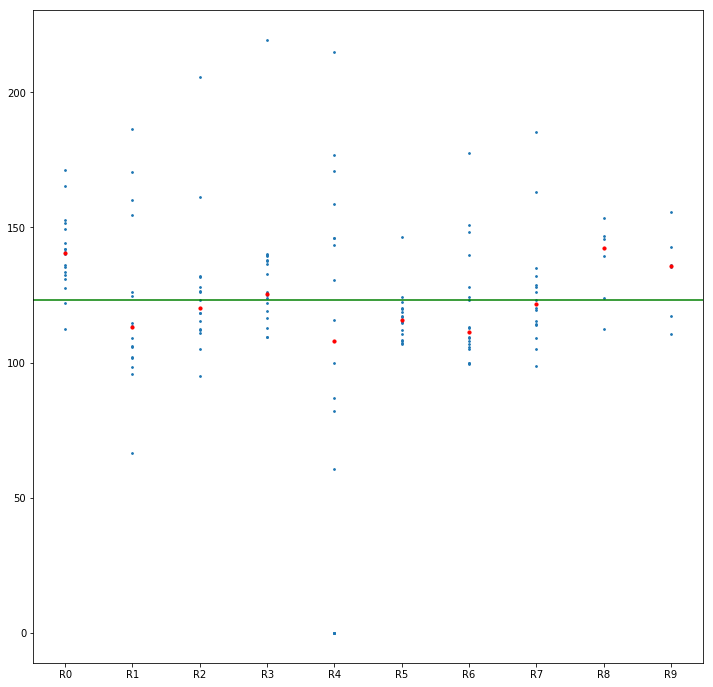

In [42]:
normalized = np.asarray(num_pixels) / np.asarray(exp_times)

av = []
for c in np.unique(im_cam):
    av.append(np.median(normalized[np.asarray(im_cam) == c]))

fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(im_cam, normalized, s=3)
plt.scatter(np.unique(im_cam), av, s=10, c="r")

plt.axhline(np.median(normalized), c="g")

27293
R6
76409


Text(0,0.5,'heights')

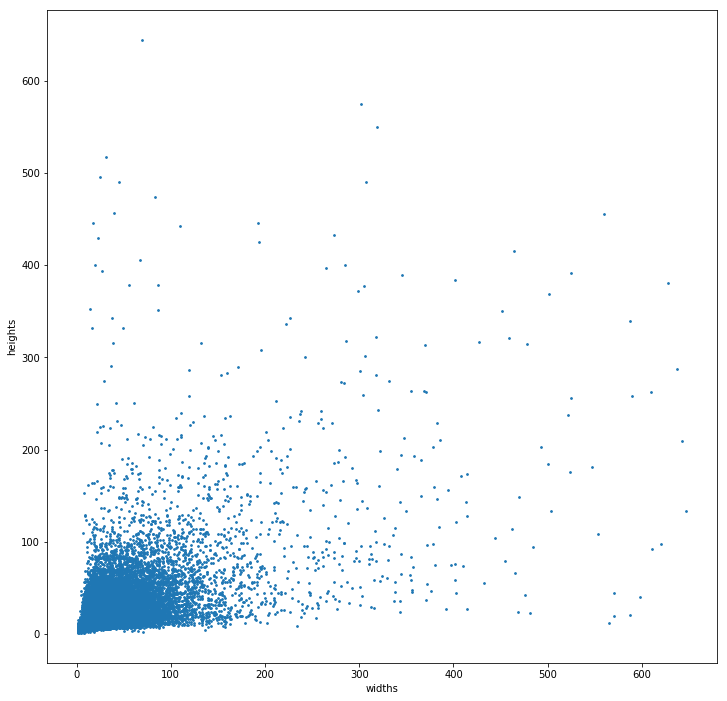

In [27]:
widths = [i.shape[1] for i in cosmics]
heights = [i.shape[0] for i in cosmics]

fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(widths, heights, s=3)
# plt.scatter(widths2, heights2, s=3)
plt.xlabel("widths")
plt.ylabel("heights")

Flooding cosmics


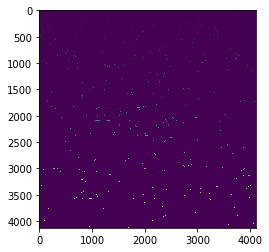

In [14]:
d,e = "20200209", "00047958"
cam = "R4"
exp_path = os.path.join(ROOT, str(d))
hdus = fits.open(os.path.join(exp_path, e, "desi-" + e + ".fits.fz"))

ii = hdus[cam].data
ii2 = subtract_bias(ii, cam, hdus)

# Join the cosmics in order to reduce the number to be closer to the true value
print("Flooding cosmics")
m = flood_cosmic2(ii2 > 250, ii2 > 3 * np.std(final))
m_binary = ndimage.convolve(m, k) # This is 50ms faster than a binary_dilation.
# m_binary = ndimage.binary_opening(m_binary, np.ones((3,3))) # Should remove hot pixels
m_labels, num_labels = ndimage.label(m_binary, structure=np.ones((3,3)))
plt.imshow(m_labels)

In [ ]:
cosmics = []
cosmic_masks = []

# Ok so 0 is the non labeled ones so we have to start at 1
for i in range(1, num_labels):
    points = np.argwhere(m_labels == i)

    # We do y this way because interplay between the origin of the array being the
    # top left of the image and the image actually being displayed in the opposite
    # vertical orientation (origin lower left)
    # This is also why the max is from the min and the min is from the max.
    # y_max = ii2.shape[0] - np.min(points[:,0])
    # y_min = ii2.shape[0] - np.max(points[:,0])
    y_min = np.min(points[:,0])
    y_max = np.max(points[:,0])
    x_min = np.min(points[:,1])
    x_max = np.max(points[:,1])

    cosmic = ii2[y_min:y_max, x_min:x_max]
    cosmics.append(cosmic)

    small_mask = m[y_min:y_max, x_min:x_max]
    cosmic_masks.append(small_mask)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 28), tight_layout=True)
m1 = dark_img > cosmic_thresh
ax[0].imshow(m_labels)

zscale = ZScaleInterval()
norm = ImageNormalize(ii2, zscale)
ax[1].imshow(ii2, norm=norm, cmap="gray")

print(y_max, y_min)

ax[0].axhline(y = y_min)
ax[0].axhline(y = y_max)
ax[0].axvline(x = x_min)
ax[0].axvline(x = x_max)

ax[1].axhline(y = y_min)
ax[1].axhline(y = y_max)
ax[1].axvline(x = x_min)
ax[1].axvline(x = x_max)